In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import squidpy as sq
import scipy.sparse as sp
from scipy.cluster import hierarchy as sch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [78]:
adata = ad.read_h5ad("adata.h5ad")

In [79]:
adata

AnnData object with n_obs × n_vars = 28317 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'

In [80]:
(adata.obs.Bregma).unique()

array([-0.04, -0.09, -0.14, -0.19, -0.24])

In [81]:
# getting each Bregma section separately 
Bregma_1=adata[adata.obs['Bregma']==-0.04]
Bregma_2=adata[adata.obs['Bregma']==-0.09]
Bregma_3=adata[adata.obs['Bregma']==-0.14]
Bregma_4=adata[adata.obs['Bregma']==-0.19]
Bregma_5=adata[adata.obs['Bregma']==-0.24]

# preprocessing

In [82]:
def BasicScanpyPreprocessing(adata, resolution=None, n_comps=50):
    sc.pp.normalize_total(adata, inplace=True) # Normalize counts per cell
    sc.pp.log1p(adata) # Logarithmize the data matrix
#     sc.pp.scale(adata) # we dont need to sscale the data
    sc.pp.pca(adata, n_comps=n_comps)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added="Leiden", resolution=resolution)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    return adata

In [83]:
BasicScanpyPreprocessing(adata, resolution=0.65, n_comps=50)
BasicScanpyPreprocessing(Bregma_1, resolution=0.65, n_comps=20)
BasicScanpyPreprocessing(Bregma_2, resolution=0.65, n_comps=20)
BasicScanpyPreprocessing(Bregma_3, resolution=0.65, n_comps=20)
BasicScanpyPreprocessing(Bregma_4, resolution=0.65, n_comps=20)
BasicScanpyPreprocessing(Bregma_5, resolution=0.65, n_comps=20)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 5543 × 155
    obs: 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'n_counts', 'Leiden', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'Leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

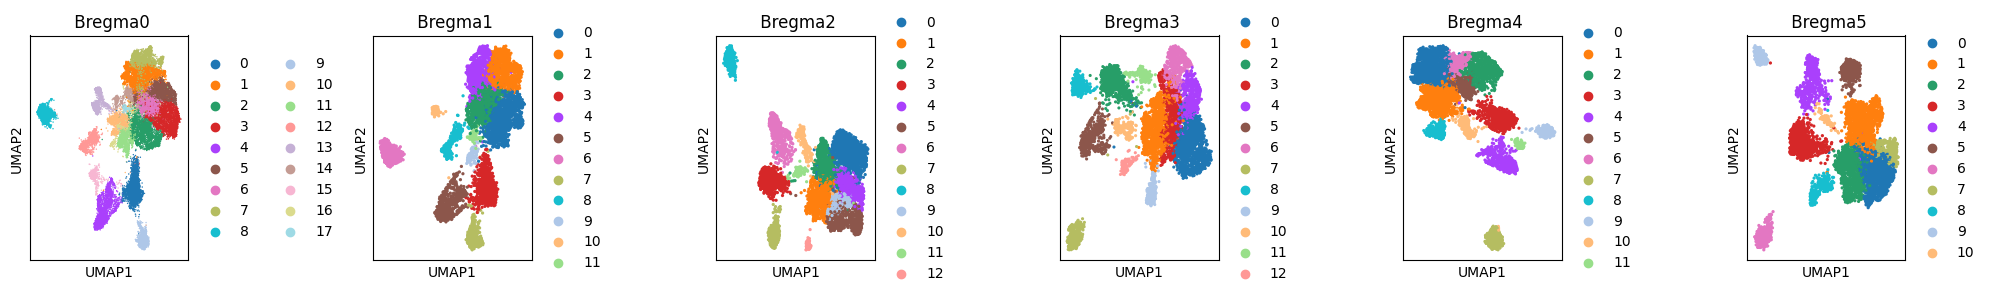

In [133]:
groups= [adata, bregma_1, bregma_2, bregma_3, bregma_4, bregma_5]
fig, axs = plt.subplots(1, 6, figsize=(20, 3))

for i, adt in enumerate(groups):

    # Plot embedding
    sc.pl.umap(adt, color=["Leiden"], wspace=0.4, ax=axs[i], show=False)

    # Set title for each subplot
    axs[i].set_title(f' Bregma{i}')

# Adjust layout
plt.tight_layout()
plt.show()

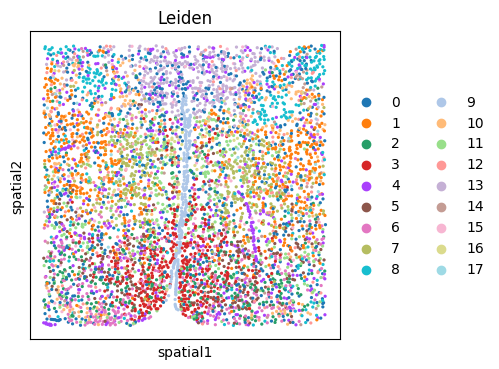

In [109]:
sc.pl.embedding(adata[adata.obs['Bregma']==-0.24], basis='spatial', color='Leiden')

# identifying cluster of the analysis of the entire dataset combined

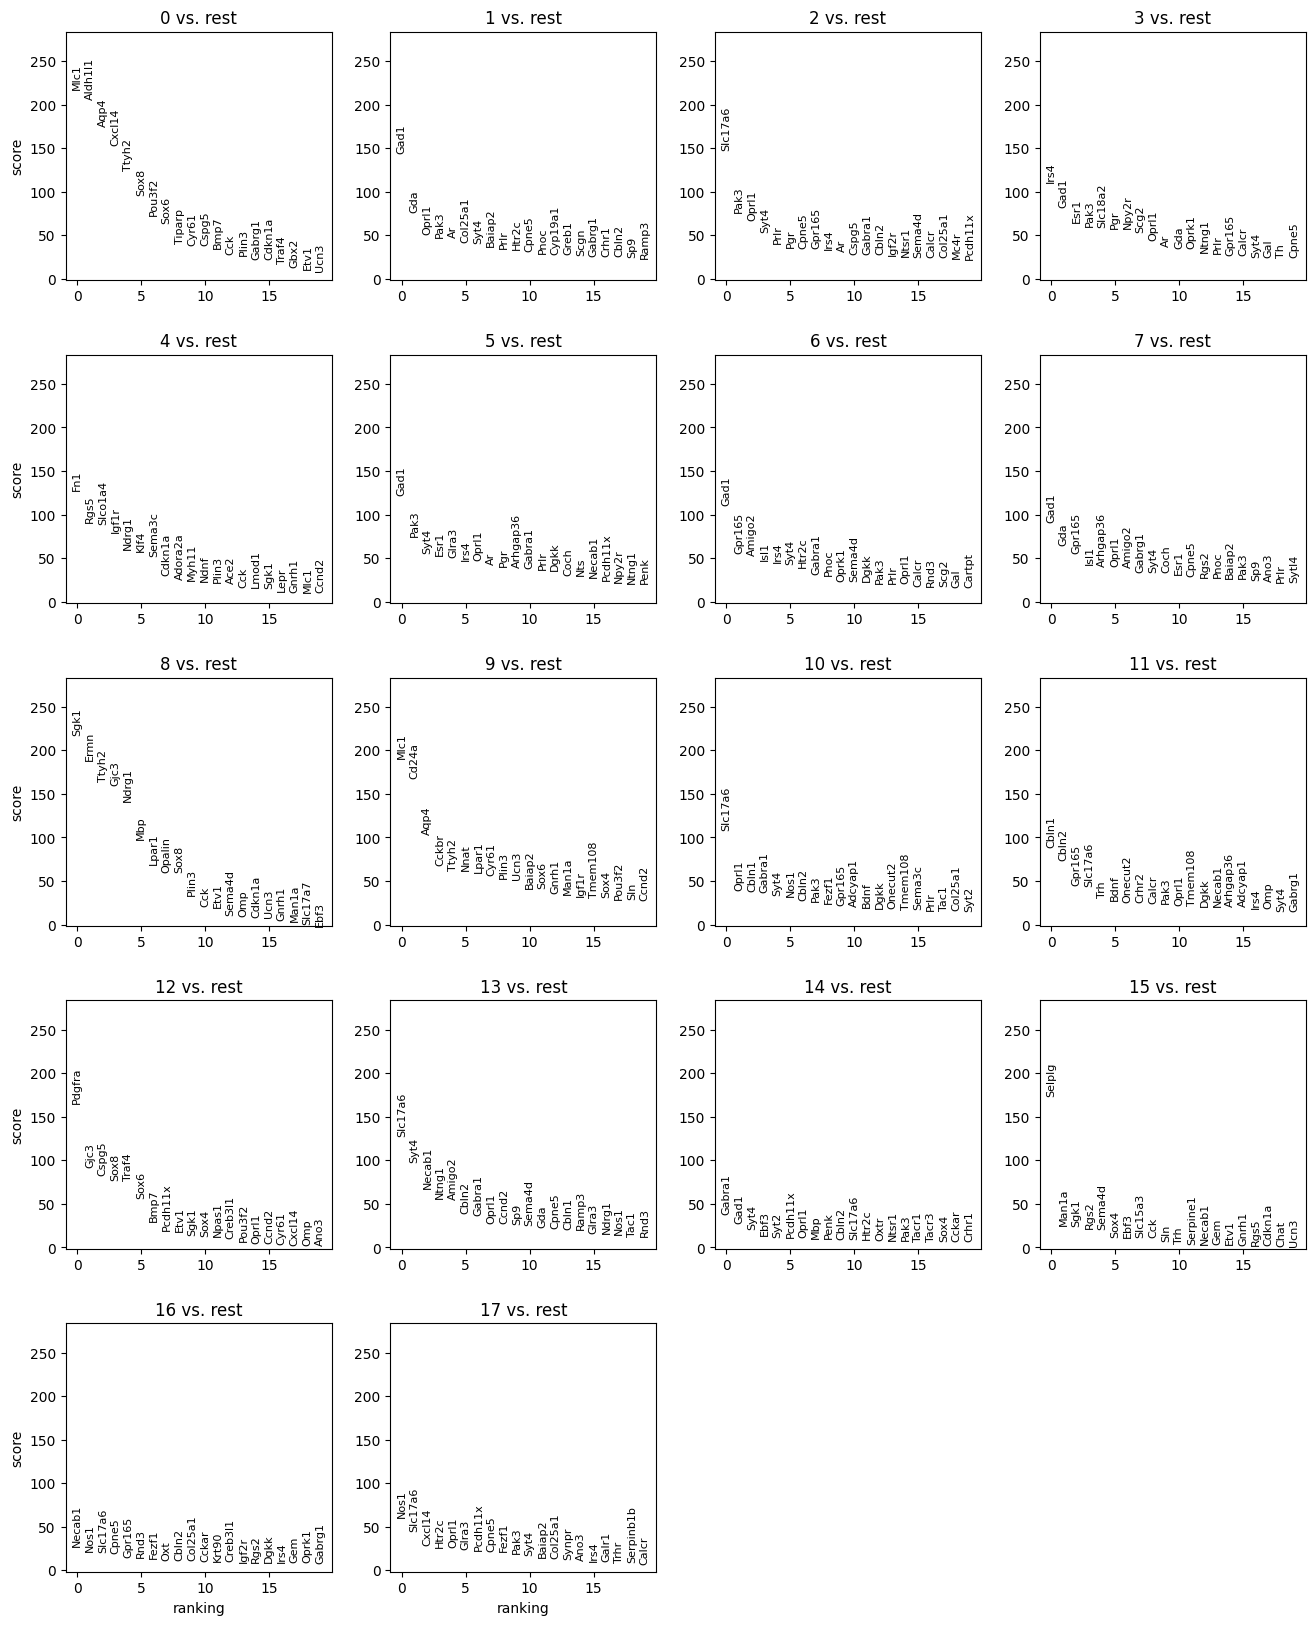

In [106]:
sc.tl.rank_genes_groups(adata, groupby="Leiden")
sc.pl.rank_genes_groups(adata, groupby="Leiden")

In [107]:
marker_genes_dict = {
    'Excitatory': ['Slc17a6','Slc17a7'],
    'Inhibitory': ['Gad1']
}

categories: 0, 1, 2, etc.
var_group_labels: Excitatory, Inhibitory


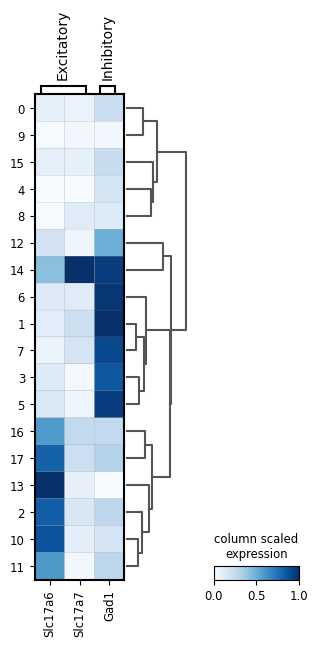

In [108]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.matrixplot(adata, marker_genes_dict, 'Leiden', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

## as defined in the heatmap cluster 16, 17, 13, 2, 10, 11 are Excitatory neruons while clusters 12, 6, 1, 7, 3, 5 are Inhibitory neurons
## cluster 14 is likely to be hybrid

In [117]:
# annotating manually based on marker genes
cluster_to_cell_type = {
    #assinging cells based on expression of ['Slc17a6','Slc17a7','Gad1']
    '16': 'Excitatory 1',
    '17': 'Excitatory 2',
    '13': 'Excitatory 3',
    '2': 'Excitatory 4',
    '10': 'Excitatory 5',
    '11': 'Excitatory 6',
    '12': 'Inhibitory 1',
    '6': 'Inhibitory 2',
    '1': 'Inhibitory 3',
    '7': 'Inhibitory 4',
    '3': 'Inhibitory 5',
    '5': 'Inhibitory 6',
    '14': 'Hybrid',
    # assinging cells based on PanglaoDB 
    '0':'Astrocytes', #based on highly variable genes [MLC1, ALDH1l1, AqP4]
    '9' :'Ependymal', # based on highly varaible genes[MLC1, GP9(cd24a), AqP4, CCKBR, ttyh2] and anatomic location 
    '15': 'Microglia', #based on highly varaible genes[selplg, man1a,sgk1]
    '4':'Endothelial', # based on highly varaible genes [fn1,rgs5,slco1a4,igf1r,klf4,sema3c]
    '8':'OD'  # based on highly varaible genes[sgk1,ermn,TTYH2,gjc3,ndrg1,mbp]
}

# Add this information to the AnnData object
adata.obs['Cell_class_2'] = adata.obs['Leiden'].map(cluster_to_cell_type)


# identifying cluster of the analysis of tissue scetions -0.19 as it's more different in clusters shape

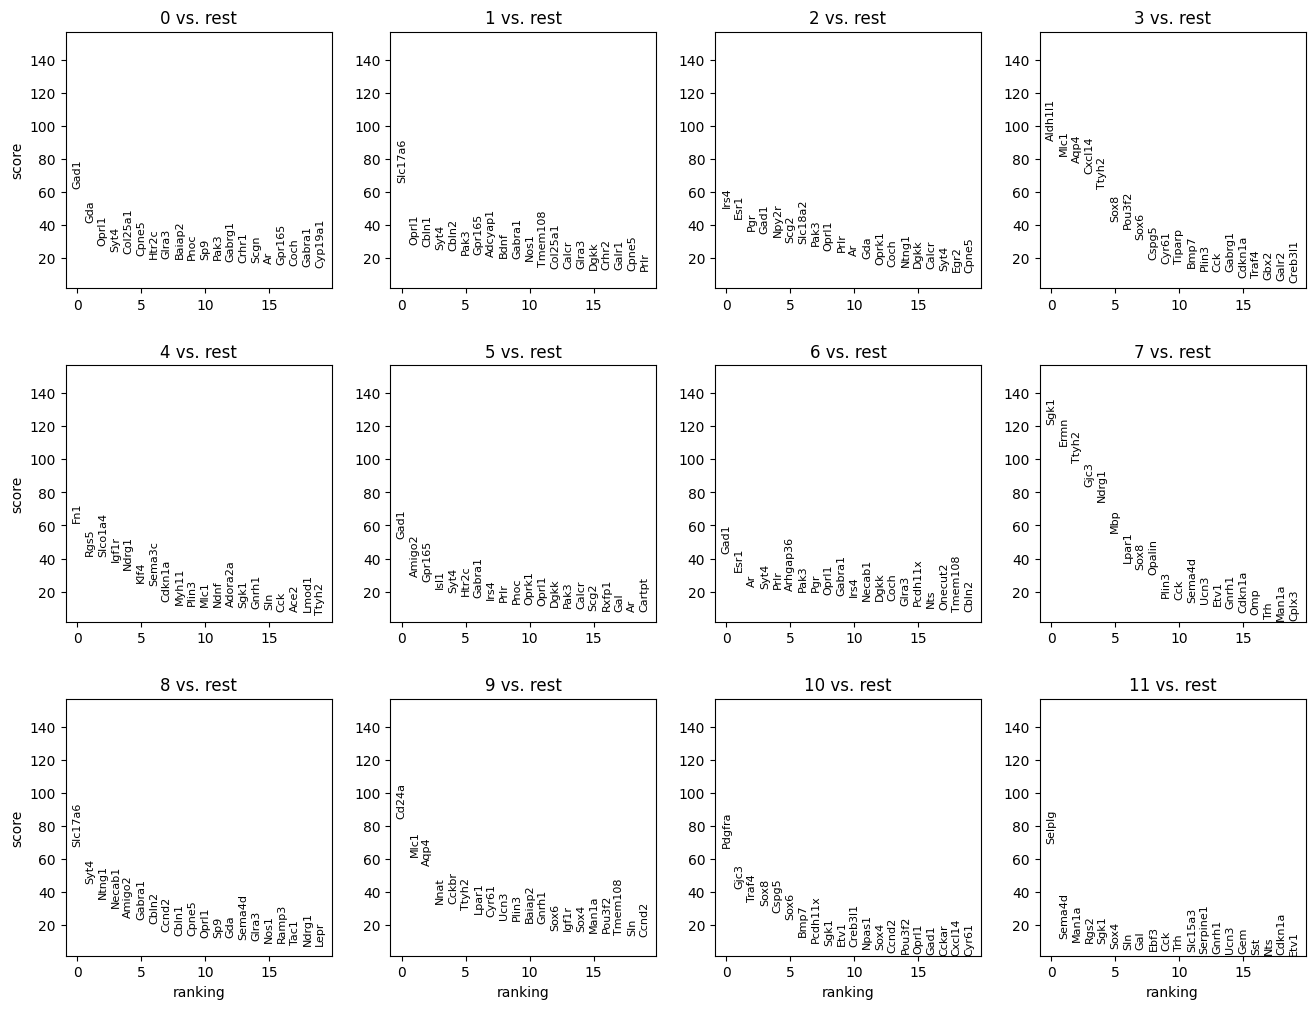

In [124]:
sc.tl.rank_genes_groups(Bregma_4, groupby="Leiden")
sc.pl.rank_genes_groups(Bregma_4, groupby="Leiden")

categories: 0, 1, 2, etc.
var_group_labels: Excitatory, Inhibitory


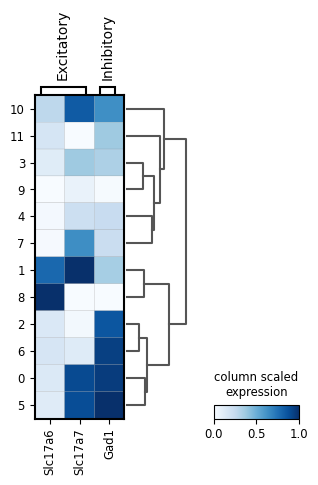

In [125]:
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.matrixplot(Bregma_4, marker_genes_dict, 'Leiden', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

# 

In [127]:
# annotating manually based on marker genes
cluster_to_cell_type = {
    #assinging cells based on expression of ['Slc17a6','Slc17a7','Gad1']
    '7': 'Excitatory 1',
    '1': 'Excitatory 2',
    '8': 'Excitatory 3',
    '2': 'Inhibitory 1',
    '6': 'Inhibitory 2',
    '10': 'Hybrid 1',
    '0': 'Hybrid 2',
    '5': 'Hybrid 3',
    # assinging cells based on PanglaoDB 
    '11':'Microglia', #based on highly varaible genes[selplg, man1a,sgk1]
    '3' :'Astrocytes', #based on highly variable genes [MLC1, ALDH1l1, AqP4]
    '9':'Ependymal', # based on highly varaible genes[MLC1, GP9(cd24a), AqP4, CCKBR, ttyh2] and anatomic location 
    '4':'Endothelial', # based on highly varaible genes [fn1,rgs5,slco1a4,igf1r,klf4,sema3c]
}

# Add this information to the AnnData object
Bregma_4.obs['Cell_class_2'] = Bregma_4.obs['Leiden'].map(cluster_to_cell_type)


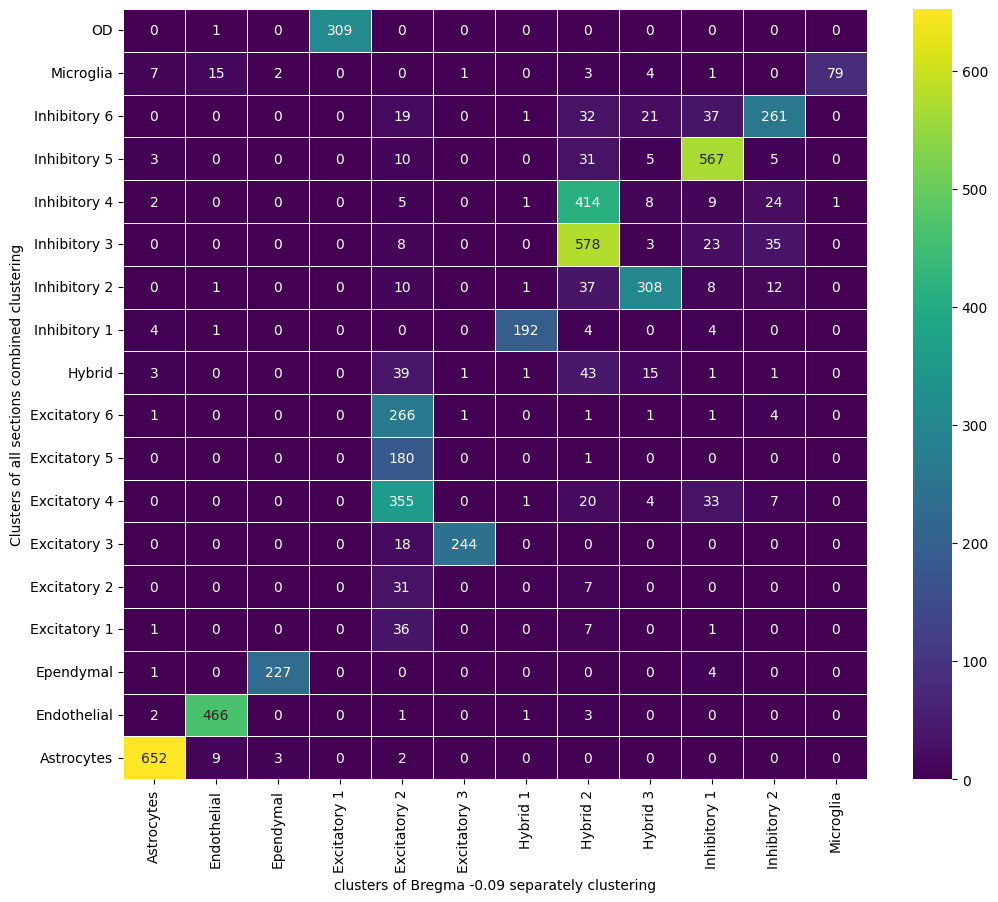

In [131]:
# Extract cluster labels
clusters_tissue1 = adata[adata.obs['Bregma']==-0.19].obs['Cell_class_2']
clusters_tissue2 = Bregma_4.obs['Cell_class_2']

# Create a DataFrame to compare clusters
data = pd.DataFrame({
    'cluster_tissue1': clusters_tissue1,
    'cluster_tissue2': clusters_tissue2
})

# Create a contingency table
contingency_table = pd.crosstab(data['cluster_tissue1'], data['cluster_tissue2'])

# Fill missing values with zeros (if any cluster pair has no overlap)
contingency_table = contingency_table.fillna(0)

# Sort clusters alphabetically
sorted_clusters_tissue1 = sorted(contingency_table.index,reverse=True)
sorted_clusters_tissue2 = sorted(contingency_table.columns)

# Reorder the contingency table based on alphabetical sorting
sorted_table = contingency_table.loc[sorted_clusters_tissue1, sorted_clusters_tissue2]

# Plot heatmap with reordered clusters
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_table, annot=True, fmt='d', cmap='viridis', linewidths=0.5)
plt.xlabel('clusters of Bregma -0.09 separately clustering')
plt.ylabel('Clusters of all sections combined clustering')
plt.show()

In [ ]:
adata.write("adata.h5ad")